In [8]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn import linear_model as lm
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
infile = 'Source_Data/master_county_datafile.csv'

In [2]:
# Create master DataFrame
data = pd.read_csv(infile)
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'county', 'state', 'county_and_state_x',
       'code', 'Deaths', 'Population', 'Crude Rate', 'fips', 'smoking',
       'obesity', 'foodenv', 'exercise', 'noinsurance', 'physicians',
       'pollution', 'diabetes', 'county_and_state_y', 'code2', 'sunlight',
       'blow', 'ganj', 'smack', 'Age Adjusted Rate', 'smoking_tr',
       'foodenv_tr', 'gauss_exercise', 'noinsurance_tr', 'physicians_tr'],
      dtype='object')

In [3]:
# A few things to remember:
#  Transforms:  (to generate normally distributed data)
#  smoking_tr = (smoking - 17.5) / 2.5 signed and raised to 0.75 power
#  foodenv_tr = foodenv / (15 - foodenv)
#  gauss_exercise = exercise ranked and transformed by noram dist cdf
#  noinsurance_tr = sqrt(noinsurance)
#  physicians_tr = log(physicians + 1)

# We will generate predicted values of the transformed parameters, so to recover
# the original parameters...
# Define the inverse transform functions

def inv_smoking (tr):
    return (np.sign(tr) * np.power(abs(tr),4/3)) * 2.5 + 17.5

def inv_foodenv (tr):
    return 15 * tr / (1.0 + tr)

def inv_noinsurance (tr):
    return tr * tr

def inv_physicians (tr):
    return exp(tr) - 1

# CAUTION: Doing the inverse of gexrank *requires* the global 'data' 
def inv_exercise (tr):
    return data.exercise.quantile(st.norm.cdf(tr),method='linear')

# Regression set-up

* We have nine county-level variables and three state-level variables -- one choice is whether to include
* We have the ability to use max data or eliminate all data with one missing parameter
* Our regression choices are "elastic net", "Ridge", "lasso", "partial least squares", "decision tree", "random forest", and "ordinary least squares"

### All factors only where all factors are present

In [4]:
# Set up the variables
fips = data.fips.values.reshape(-1)
xfactors = ['smoking_tr','obesity','foodenv_tr','gauss_exercise','noinsurance_tr',
           'physicians_tr','pollution','diabetes','sunlight','blow','ganj','smack']
ymeasured = ['Crude Rate']
dataused = data[xfactors + ymeasured].dropna(how='any')
X = dataused[xfactors].values
Y = dataused[ymeasured].values.reshape(-1)
len(dataused)

2804

In [5]:
# Do the train and test split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=.3, random_state=42)
# Set up regression object
regr = lm.LinearRegression(normalize=True)
# Fit regression
regr.fit(Xtrain,Ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [6]:
#Report coefficients and score
for a,b in zip(xfactors,regr.coef_):
    print(a,b)
print(f'intercept: {regr.intercept_}')

smoking_tr -5.594067607295691
obesity 0.32374956770343877
foodenv_tr -58.71264204595781
gauss_exercise 21.78341017112285
noinsurance_tr -52.96948455899125
physicians_tr -6.560477449406859
pollution -7.463384341851538
diabetes 15.996494258232216
sunlight -0.013183252079403232
blow -1.1864135158343503
ganj -0.34805499829778463
smack -92.19950111778886
intercept: 559.5246896070748


In [7]:
# Predict and score
regr.score(Xtest,Ytest)

0.26438010419032

##### How do we interpret the coefficients?  For each variable, this depends on our assumptions:

* For smoking, we have to consider both a personal effect, where the rate difference is the derivative of the inverse transformed value... however, we note that the transformation does not change values at 15% and 20% rates, so we can interpret the coefficient as half the effect of going from a 15% to a 20% rate.  So, in a simple "individual driven" model, the rate effect is 40 x the coefficient, in risk per year per 100,000.
* Obesity is not transformed, so in a "personal risk" model, the rate difference is 100 x the coefficient.  
* Diabetes is not transformed, so in a "personal risk" model, the rate difference is 100 x the coefficient.
* For blow, ganj, and smoke, the same rule applies...
* For physicians, the transform is a log, so the effect is what happens when multiplying your visits to the doctor by 10x
* For noinsurance_tr, the transform is the squart root, so the derivative is just the transformed derivative divided by 2 * the squared value of the mean transform, which is 2 * .326 * .326 = 0.212, so on a "personal level", the effect is 0.212 x the coefficient
* For environmental variables, we will use a "25th percentile to 75th percentile" measure, i.e, the effect of moving from a county in the 25th percentile to one in the 75th percentile.  Because the exercise is Gaussian transformed and ranked, we just need the z-scores for these percentiles (+ and - 0.674).  So, the effect is 1.349 x the coefficient, but inverted because a higher score gets a lower rank, so multiple the coefficient by -1.349
* For the remaining variables, we need the quartiles, they are:
* For foodenv_tr, 25th percentile = 0.851, 75th percentile = 1.206, so the effect is 0.349 x the coefficient
* For pollution, 25th = 7.7, 75th = 10.4, so the effect is 2.7 x the coefficient, but higher is worse, so use -2.7
* For sunlight, 25th = 14826.12, 75th = 17149.11, so the effect is 2323 x the coefficient

In [8]:
# Capture these results in an effects matrix
effects = np.array([40, 100, 0.349, -1.349, 0.212, 1, -2.7, 100, 2323, 100, 100, 100])

In [9]:
# Test parameter sensitivity to x-val selection
coeff = []
impacts = []
risks = []
intercepts = []
scores = []
for ix in range(100):
    # Do the train and test split
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=.3, random_state=np.random.randint(255))
    # Set up regression object
    regr = lm.LinearRegression(normalize=True)
    # Fit regression
    regr.fit(Xtrain,Ytrain)
    # Append parameters to list
    coeff.append(regr.coef_)
    impacts.append(np.multiply(regr.coef_,effects))
    risks.append(np.multiply(regr.coef_,effects) / np.mean(Ytrain))
    intercepts.append(regr.intercept_)
    scores.append(regr.score(Xtest,Ytest))
ols_all_nona_df = pd.DataFrame(columns=xfactors,data=coeff)
ols_all_nona_df['Intercept'] = intercepts
ols_all_nona_df['Score'] = scores
ols_all_nona_df2 = pd.DataFrame(columns=xfactors,data=impacts)
ols_all_nona_df3 = pd.DataFrame(columns=xfactors,data=risks)

In [10]:
ols_all_nona_df.describe()

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight,blow,ganj,smack,Intercept,Score
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-8.295896,0.014353,-57.207521,22.987939,-49.482170,-7.091766,-8.378575,16.658924,-0.014073,-5.135193,-0.796579,-76.432752,592.554530,0.280925
std,1.932615,0.383958,5.949844,2.174876,22.425734,3.243964,0.735397,0.686650,0.001244,3.939749,0.637722,12.142216,29.583617,0.025126
min,-13.883967,-1.039362,-68.894677,17.691166,-96.701188,-13.871972,-10.233880,15.402991,-0.017519,-13.684769,-2.157470,-107.067806,504.565580,0.226413
25%,-9.480728,-0.204144,-61.219009,21.497547,-65.496381,-9.563938,-8.810822,16.102154,-0.014871,-7.961488,-1.176668,-84.679518,574.545230,0.264645
50%,-8.126016,0.025937,-58.252634,22.703304,-52.202850,-6.974272,-8.443210,16.607748,-0.013973,-5.184952,-0.859073,-79.009311,592.301835,0.281142
75%,-6.987248,0.278706,-54.098169,24.476496,-35.631488,-4.490210,-7.844790,17.148055,-0.013309,-2.047144,-0.386211,-64.901243,615.654470,0.295974
max,-3.655083,0.813017,-39.119147,28.374675,1.785026,-0.697623,-6.760077,18.566848,-0.011062,2.758159,0.957025,-52.752212,662.145680,0.341179


In [11]:
ols_all_nona_df2.describe()

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight,blow,ganj,smack
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-331.835851,1.435272,-19.965425,-31.010730,-10.490220,-7.091766,22.622152,1665.892362,-32.691837,-513.519265,-79.657868,-7643.275216
std,77.304580,38.395773,2.076495,2.933908,4.754256,3.243964,1.985573,68.665020,2.890125,393.974904,63.772152,1214.221619
min,-555.358696,-103.936244,-24.044242,-38.277437,-20.500652,-13.871972,18.252207,1540.299080,-40.695597,-1368.476937,-215.747009,-10706.780575
25%,-379.229125,-20.414418,-21.365434,-33.018793,-13.885233,-9.563938,21.180932,1610.215420,-34.544804,-796.148793,-117.666840,-8467.951818
50%,-325.040635,2.593692,-20.330169,-30.626757,-11.067004,-6.974272,22.796666,1660.774799,-32.458770,-518.495243,-85.907311,-7900.931057
75%,-279.489905,27.870609,-18.880261,-29.000190,-7.553876,-4.490210,23.789219,1714.805539,-30.917027,-204.714393,-38.621106,-6490.124270
max,-146.203308,81.301679,-13.652582,-23.865383,0.378426,-0.697623,27.631476,1856.684804,-25.697578,275.815899,95.702465,-5275.221206


In [12]:
ols_all_nona_df3.describe()

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight,blow,ganj,smack
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.981091,0.004288,-0.059023,-0.091680,-0.031012,-0.020962,0.066869,4.925021,-0.096653,-1.516931,-0.235391,-22.597543
std,0.228764,0.113472,0.006127,0.008704,0.014046,0.009590,0.005765,0.206251,0.008615,1.164250,0.188150,3.599116
min,-1.640139,-0.305225,-0.071087,-0.113535,-0.061064,-0.041090,0.054033,4.569441,-0.120266,-4.065181,-0.632517,-31.527585
25%,-1.123831,-0.060394,-0.063488,-0.097184,-0.041000,-0.028201,0.062640,4.763143,-0.101838,-2.346995,-0.348679,-24.896926
50%,-0.959719,0.007738,-0.060113,-0.090724,-0.032785,-0.020617,0.067457,4.896144,-0.095953,-1.541157,-0.254039,-23.403020
75%,-0.825842,0.082562,-0.055983,-0.085665,-0.022169,-0.013275,0.070406,5.083787,-0.091434,-0.606262,-0.114104,-19.207352
max,-0.429025,0.240118,-0.040202,-0.070282,0.001122,-0.002069,0.081620,5.515446,-0.076441,0.821560,0.282779,-15.562446


Personal habits seem far more important than environmental factors, but the signs do not agree with known findings.  These data are not age adjusted, which can lead to significant confounding of effects.

### Age Adjusted Rates, Data only for counties where all county and state factors known, Ordinary Least Squares

In [17]:
# Set up the variables
fips = data.fips.values.reshape(-1)
xfactors = ['smoking_tr','obesity']
#'foodenv_tr','gauss_exercise','noinsurance_tr',
#           'physicians_tr','pollution','diabetes','sunlight','blow','ganj','smack']
ymeasured = ['Age Adjusted Rate']
dataused = data[xfactors + ymeasured].dropna(how='any')
X = dataused[xfactors].values
Y = dataused[ymeasured].values.reshape(-1)
len(dataused)

3066

In [18]:
regr = lm.LinearRegression(normalize=True)
regr.fit(X,Y)
regr.score(X,Y)

0.3656235678313664

In [14]:
# Test parameter sensitivity to x-val selection
coeff = []
impacts = []
risks = []
intercepts = []
scores = []
for ix in range(100):
    # Do the train and test split
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=.3, random_state=np.random.randint(255))
    # Set up regression object
    regr = lm.LinearRegression(normalize=True)
    # Fit regression
    regr.fit(Xtrain,Ytrain)
    # Append parameters to list
    coeff.append(regr.coef_)
    impacts.append(np.multiply(regr.coef_,effects))
    risks.append(np.multiply(regr.coef_,effects) / np.mean(Ytrain))
    intercepts.append(regr.intercept_)
    scores.append(regr.score(Xtest,Ytest))
ols_all_nona_df = pd.DataFrame(columns=xfactors,data=coeff)
ols_all_nona_df['Intercept'] = intercepts
ols_all_nona_df['Score'] = scores
ols_all_nona_df2 = pd.DataFrame(columns=xfactors,data=impacts)
ols_all_nona_df3 = pd.DataFrame(columns=xfactors,data=risks)


In [15]:
ols_all_nona_df.describe()

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight,blow,ganj,smack,Intercept,Score
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,15.530463,1.369172,-28.036915,4.101455,22.499767,-4.111048,3.695433,2.624008,0.003387,-1.699199,-1.312240,-8.972363,140.318509,0.440508
std,0.793630,0.192523,3.211220,0.934607,11.386422,1.385746,0.337146,0.374749,0.000541,1.960067,0.280599,4.928954,16.225043,0.024443
min,13.822686,0.877930,-36.438436,1.795643,-4.650421,-7.048686,2.805758,1.478330,0.001633,-7.173756,-1.947853,-24.058370,97.534935,0.361140
25%,14.874960,1.227868,-30.739385,3.573124,14.157425,-5.091817,3.475753,2.397157,0.003044,-3.307457,-1.513533,-12.278949,128.050010,0.423872
50%,15.484356,1.373645,-27.783231,4.148665,23.070650,-4.088130,3.687248,2.658316,0.003386,-1.695009,-1.292806,-8.577478,142.833117,0.440548
75%,16.217488,1.517088,-25.933250,4.724289,30.239035,-2.980422,3.955181,2.878848,0.003835,-0.244826,-1.098197,-5.138954,150.939501,0.454829
max,17.349591,1.820825,-21.471669,6.920591,53.481482,-0.899261,4.651073,3.334695,0.004646,2.784758,-0.775712,3.706385,181.403226,0.511632


In [16]:
ols_all_nona_df2.describe()

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight,blow,ganj,smack
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,621.218532,136.917194,-9.784883,-5.532863,4.769951,-4.111048,-9.977670,262.400780,7.868168,-169.919893,-131.224046,-897.236262
std,31.745186,19.252339,1.120716,1.260784,2.413921,1.385746,0.910295,37.474916,1.255960,196.006727,28.059872,492.895408
min,552.907434,87.792996,-12.717014,-9.335878,-0.985889,-7.048686,-12.557898,147.833021,3.792647,-717.375631,-194.785313,-2405.837049
25%,594.998384,122.786758,-10.728045,-6.373065,3.001374,-5.091817,-10.678988,239.715710,7.071847,-330.745694,-151.353279,-1227.894887
50%,619.374229,137.364479,-9.696348,-5.596549,4.890978,-4.088130,-9.955569,265.831584,7.866191,-169.500944,-129.280632,-857.747783
75%,648.699508,151.708839,-9.050704,-4.820144,6.410675,-2.980422,-9.384534,287.884770,8.908970,-24.482595,-109.819697,-513.895363
max,693.983653,182.082543,-7.493613,-2.422322,11.338074,-0.899261,-7.575545,333.469514,10.792450,278.475812,-77.571238,370.638450


In [17]:
ols_all_nona_df3.describe()

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight,blow,ganj,smack
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.512689,0.553774,-0.039578,-0.022377,0.019291,-0.016628,-0.040360,1.061433,0.031825,-0.687390,-0.530799,-3.629314
std,0.127729,0.077635,0.004529,0.005088,0.009756,0.005600,0.003702,0.151970,0.005075,0.792986,0.113533,1.993081
min,2.229264,0.354707,-0.051241,-0.037628,-0.003980,-0.028479,-0.050604,0.597386,0.015363,-2.902116,-0.785393,-9.727308
25%,2.415209,0.499891,-0.043673,-0.025712,0.012132,-0.020548,-0.043244,0.968257,0.028625,-1.338440,-0.612015,-4.975315
50%,2.502203,0.555752,-0.039128,-0.022591,0.019769,-0.016557,-0.040421,1.071964,0.031811,-0.685685,-0.522894,-3.457117
75%,2.618142,0.612360,-0.036629,-0.019508,0.025866,-0.012044,-0.038050,1.163181,0.035930,-0.098676,-0.444044,-2.071191
max,2.804356,0.734137,-0.030275,-0.009834,0.045688,-0.003638,-0.030692,1.352690,0.043660,1.125308,-0.312759,1.499404


Once we use age adjusted rates, the smoking, diabetes, and obesity factors dominate, and environmental factors are still small but mostly consistent.  Drug use is still negatively correlated, though...

### Use county data only for counties with all factors known, ordinary least squares...

In [18]:
# Set up the variables
fips = data.fips.values.reshape(-1)
xfactors = ['smoking_tr','obesity','foodenv_tr','gauss_exercise','noinsurance_tr',
           'physicians_tr','pollution','diabetes','sunlight']
ymeasured = ['Age Adjusted Rate']
effects2 = np.array([40, 100, 0.349, -1.349, 0.212, 1, -2.7, 100, 2323])
dataused = data[xfactors + ymeasured].dropna(how='any')
X = dataused[xfactors].values
Y = dataused[ymeasured].values.reshape(-1)
len(dataused)

2915

In [19]:
# Test parameter sensitivity to x-val selection
coeff = []
impacts = []
risks = []
intercepts = []
scores = []
for ix in range(100):
    # Do the train and test split
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=.3, random_state=np.random.randint(255))
    # Set up regression object
    regr = lm.LinearRegression(normalize=True)
    # Fit regression
    regr.fit(Xtrain,Ytrain)
    # Append parameters to list
    coeff.append(regr.coef_)
    impacts.append(np.multiply(regr.coef_,effects2))
    risks.append(np.multiply(regr.coef_,effects2) /np.mean(Ytrain))
    intercepts.append(regr.intercept_)
    scores.append(regr.score(Xtest,Ytest))
ols_cty_nona_df = pd.DataFrame(columns=xfactors,data=coeff)
ols_cty_nona_df['Intercept'] = intercepts
ols_cty_nona_df['Score'] = scores
ols_cty_nona_df2 = pd.DataFrame(columns=xfactors,data=impacts)
ols_cty_nona_df3 = pd.DataFrame(columns=xfactors,data=risks)

In [20]:
ols_cty_nona_df.describe()

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight,Intercept,Score
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,14.194695,1.879663,-28.117506,4.485812,48.248913,-4.040556,4.100581,2.606069,0.003461,89.463556,0.438202
std,0.728753,0.191792,3.379455,0.979949,12.410320,1.497828,0.344640,0.376805,0.000556,15.518158,0.024001
min,12.468435,1.430833,-34.787772,2.171373,20.522368,-7.199955,3.279954,1.439629,0.001941,56.959675,0.388224
25%,13.718429,1.794203,-30.436416,3.797768,39.644228,-5.273794,3.854398,2.308307,0.003036,78.410526,0.418413
50%,14.051674,1.883768,-28.127997,4.481629,47.185962,-3.894611,4.153315,2.600333,0.003456,88.196590,0.437366
75%,14.641665,2.030118,-26.309111,5.071294,56.065323,-3.002282,4.314606,2.869032,0.003782,102.147608,0.455842
max,16.117254,2.345569,-18.918852,7.365906,81.039865,-1.018896,5.021031,3.430675,0.005029,127.457960,0.484364


In [21]:
ols_cty_nona_df2.describe()

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,567.787815,187.966331,-9.813010,-6.051361,10.228770,-4.040556,-11.071570,260.606908,8.039884
std,29.150139,19.179193,1.179430,1.321952,2.630988,1.497828,0.930527,37.680510,1.290757
min,498.737410,143.083321,-12.140932,-9.936608,4.350742,-7.199955,-13.556783,143.962904,4.509303
25%,548.737166,179.420273,-10.622309,-6.841175,8.404576,-5.273794,-11.649435,230.830726,7.052963
50%,562.066951,188.376840,-9.816671,-6.045717,10.003424,-3.894611,-11.213950,260.033301,8.029299
75%,585.666618,203.011834,-9.181880,-5.123190,11.885848,-3.002282,-10.406874,286.903237,8.785673
max,644.690153,234.556883,-6.602679,-2.929182,17.180451,-1.018896,-8.855877,343.067455,11.681844


In [22]:
ols_cty_nona_df3.describe()

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.295561,0.759914,-0.039673,-0.024463,0.041354,-0.016332,-0.044764,1.053737,0.032503
std,0.117827,0.077199,0.004757,0.005334,0.010626,0.006043,0.003772,0.152983,0.005202
min,2.019495,0.577715,-0.048916,-0.040049,0.017541,-0.029158,-0.054629,0.581747,0.018266
25%,2.220727,0.725666,-0.042871,-0.027637,0.034073,-0.021276,-0.047129,0.936493,0.028610
50%,2.270532,0.762442,-0.039743,-0.024392,0.040491,-0.015785,-0.045277,1.052435,0.032489
75%,2.365435,0.819597,-0.037113,-0.020778,0.047990,-0.012115,-0.042090,1.164177,0.035577
max,2.612448,0.942682,-0.026756,-0.011892,0.069293,-0.004127,-0.035712,1.385172,0.047099


In [23]:
u =-1* abs(ols_cty_nona_df3.mean() / ols_cty_nona_df3.std())
v = st.t.cdf(u,98)
v
# P values for smoking, obesity, food environment, exercise, no insurance,
# physicians, pollution, diabetes, and sunlight 

array([8.92271832e-36, 1.32232792e-16, 2.37669037e-13, 6.67684698e-06,
       9.08225866e-05, 4.05479182e-03, 5.72299374e-21, 2.73467798e-10,
       5.38376926e-09])

### Try a decision tree 

In [24]:
# Set up the variables
fips = data.fips.values.reshape(-1)
xfactors = ['smoking_tr','obesity','foodenv_tr','gauss_exercise','noinsurance_tr',
           'physicians_tr','pollution','diabetes','sunlight']
ymeasured = ['Age Adjusted Rate']
dataused = data[xfactors + ymeasured].dropna(how='any')
X = dataused[xfactors].values
Y = dataused[ymeasured].values.reshape(-1)
len(dataused)

2915

In [25]:
# Initialize
scores = []
fis = []
# Set training and test 
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=.3, random_state=np.random.randint(255))
# Set up regression object
for n in range(2,10):
    regr = RandomForestRegressor(max_depth=n,random_state=42,n_estimators=100)
    # Fit regression
    regr.fit(Xtrain,Ytrain)
    # Append parameters to list
    scores.append(regr.score(Xtest,Ytest))
    fis.append(regr.feature_importances_)

In [26]:
scores

[0.3242920923592225,
 0.3784686832646418,
 0.40692892856193513,
 0.42067541404305947,
 0.4285939760404108,
 0.43093633216085947,
 0.43334141101598794,
 0.43283233426243484]

In [27]:
rff_df = pd.DataFrame(columns=xfactors,data=fis)

In [28]:
rff_df

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight
0,0.840030,0.036754,0.002635,0.008929,0.033653,0.000000,0.000000,0.034384,0.043616
1,0.726652,0.049402,0.020518,0.023514,0.053499,0.004288,0.016917,0.049528,0.055683
2,0.648306,0.053478,0.031616,0.040257,0.057324,0.012818,0.033856,0.050642,0.071703
3,0.587398,0.055342,0.039727,0.052036,0.057807,0.023666,0.047436,0.054912,0.081676
4,0.534966,0.057583,0.048755,0.064026,0.059750,0.033989,0.056437,0.057138,0.087356
5,0.492452,0.059489,0.054450,0.072255,0.063026,0.043276,0.064042,0.057955,0.093056
6,0.458068,0.061797,0.059331,0.077246,0.063980,0.051316,0.069240,0.060184,0.098839
7,0.431349,0.063115,0.062419,0.082704,0.065521,0.058934,0.074424,0.060563,0.100972


### Check more robust regressions ... 

In [29]:
# Set up the variables
fips = data.fips.values.reshape(-1)
xfactors = ['smoking_tr','obesity','foodenv_tr','gauss_exercise','noinsurance_tr',
           'physicians_tr','pollution','diabetes','sunlight']
ymeasured = ['Age Adjusted Rate']
dataused = data[xfactors + ymeasured].dropna(how='any')
X = dataused[xfactors].values
Y = dataused[ymeasured].values.reshape(-1)
len(dataused)

2915

In [30]:
# Test parameter sensitivity to x-val selection
coeff = []
impacts = []
risks = []
intercepts = []
scores = []
l1rs = []
for ix in range(100):
    # Do the train and test split
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=.3, random_state=np.random.randint(255))
    # Set up regression object
    regr = ElasticNetCV(l1_ratio=[0.1,0.3,0.5,0.7,0.8,0.9,0.95,0.97,0.99,1],normalize=True,cv=5)
    # Fit regression
    regr.fit(Xtrain,Ytrain)
    # Append parameters to list
    coeff.append(regr.coef_)
    impacts.append(np.multiply(regr.coef_,effects2))
    risks.append(np.multiply(regr.coef_,effects2) / np.mean(Ytrain))
    intercepts.append(regr.intercept_)
    scores.append(regr.score(Xtest,Ytest))
    l1rs.append(regr.l1_ratio_)
en_cty_nona_df = pd.DataFrame(columns=xfactors,data=coeff)
en_cty_nona_df['Intercept'] = intercepts
en_cty_nona_df['Score'] = scores
en_cty_nona_df['l1_ratio'] = l1rs
en_cty_nona_df2 = pd.DataFrame(columns=xfactors,data=impacts)
en_cty_nona_df3 = pd.DataFrame(columns=xfactors,data=risks)

In [31]:
en_cty_nona_df.describe()

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight,Intercept,Score,l1_ratio
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,12.988210,1.828622,-28.552260,4.397598,48.560447,-4.223697,3.886781,2.857323,0.002984,99.048406,0.439880,0.958000
std,0.771675,0.152872,2.901757,0.840835,9.584403,1.168756,0.247407,0.317358,0.000405,12.520138,0.023461,0.010636
min,11.517408,1.462433,-35.727454,2.305139,26.705729,-6.811680,3.261640,1.943633,0.001822,59.150835,0.395666,0.950000
25%,12.481380,1.742902,-30.515153,3.891673,43.242553,-5.150441,3.691901,2.671565,0.002727,91.756406,0.424226,0.950000
50%,12.879600,1.818870,-28.311956,4.407816,47.809675,-4.037750,3.912039,2.896198,0.002940,102.054442,0.435424,0.950000
75%,13.560744,1.931962,-27.287836,5.000284,55.993068,-3.410395,4.081728,3.078826,0.003285,108.644870,0.450968,0.970000
max,14.955625,2.205241,-20.054995,6.419102,77.037514,-1.434710,4.436655,3.473259,0.004078,128.970026,0.506077,0.990000


In [32]:
en_cty_nona_df3.describe()

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.101971,0.739825,-0.040314,-0.024000,0.041648,-0.017086,-0.042460,1.156110,0.028048
std,0.124862,0.061569,0.004070,0.004581,0.008199,0.004719,0.002708,0.128903,0.003794
min,1.870193,0.590473,-0.050644,-0.034992,0.022831,-0.027666,-0.048513,0.785413,0.017154
25%,2.014027,0.705856,-0.043043,-0.027356,0.037065,-0.020780,-0.044541,1.080576,0.025566
50%,2.082139,0.736158,-0.039981,-0.024123,0.040880,-0.016312,-0.042869,1.174313,0.027696
75%,2.203273,0.780512,-0.038542,-0.021292,0.048102,-0.013788,-0.040291,1.246601,0.030798
max,2.422268,0.895242,-0.028346,-0.012620,0.065871,-0.005824,-0.035512,1.402366,0.038209


Not surprisingly, penalizing large parameters decreases the impact of smoking somewhat, and increases the impact of diabetes, but does not make major changes.  The small factors are generally the same.  

How do these methods impact the sensitivity of the factors to each other?

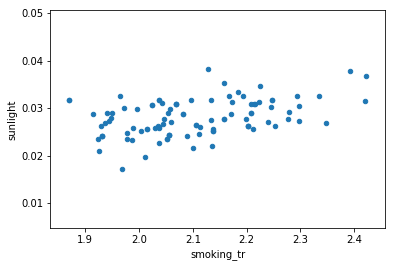

In [33]:
en_cty_nona_df3.plot(x='smoking_tr',y='sunlight',kind='scatter')

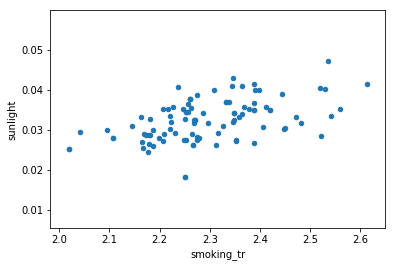

In [34]:
ols_cty_nona_df3.plot(x='smoking_tr',y='sunlight',kind='scatter')

The elastic net results are less noisy, and the counfidng effects are more apparent, but what about the absolute magnitude of the effect?  For that we need quick coefficients.

In [35]:
regr = lm.LinearRegression()
regr.fit(en_cty_nona_df3.smoking_tr.values.reshape(-1,1),en_cty_nona_df3.sunlight.values.reshape(-1,1))
regr.coef_

array([[0.01274468]])

In [36]:
regr = lm.LinearRegression()
regr.fit(ols_cty_nona_df3.smoking_tr.values.reshape(-1,1),ols_cty_nona_df3.sunlight.values.reshape(-1,1))
regr.coef_

array([[0.02220671]])

So, in fact OLS is a bit less confounded... and given that we aren't off by more than 1 or 2, the level is tolerable.  Let's check the other factors quickly... 

In [37]:
corr_df = pd.DataFrame(en_cty_nona_df3.corr())
corr_df

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight
smoking_tr,1.000000,0.031034,0.216489,0.087038,-0.290916,0.094731,-0.044402,-0.514277,0.419469
obesity,0.031034,1.000000,0.257167,0.159254,0.205472,0.163857,0.048634,-0.506075,0.321448
foodenv_tr,0.216489,0.257167,1.000000,0.167362,0.243521,0.077436,-0.160233,-0.003341,0.297699
gauss_exercise,0.087038,0.159254,0.167362,1.000000,0.171982,-0.435890,-0.143294,0.104288,-0.067345
noinsurance_tr,-0.290916,0.205472,0.243521,0.171982,1.000000,-0.017931,-0.196423,-0.026874,-0.176498
physicians_tr,0.094731,0.163857,0.077436,-0.435890,-0.017931,1.000000,0.100390,-0.007071,0.242371
pollution,-0.044402,0.048634,-0.160233,-0.143294,-0.196423,0.100390,1.000000,0.118445,0.072163
diabetes,-0.514277,-0.506075,-0.003341,0.104288,-0.026874,-0.007071,0.118445,1.000000,-0.246026
sunlight,0.419469,0.321448,0.297699,-0.067345,-0.176498,0.242371,0.072163,-0.246026,1.000000


In [38]:
corr_df = pd.DataFrame(ols_cty_nona_df3.corr())
corr_df

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight
smoking_tr,1.000000,0.031970,0.441943,-0.070106,-0.165816,0.223382,0.064033,-0.426579,0.502998
obesity,0.031970,1.000000,0.249744,0.370103,0.198219,0.101685,-0.064903,-0.527338,0.357468
foodenv_tr,0.441943,0.249744,1.000000,-0.045591,0.144155,0.238412,-0.103157,-0.188545,0.454144
gauss_exercise,-0.070106,0.370103,-0.045591,1.000000,0.146626,-0.259167,0.047648,0.032132,0.068771
noinsurance_tr,-0.165816,0.198219,0.144155,0.146626,1.000000,-0.079287,-0.261649,-0.212891,-0.442579
physicians_tr,0.223382,0.101685,0.238412,-0.259167,-0.079287,1.000000,-0.009097,0.104670,0.183572
pollution,0.064033,-0.064903,-0.103157,0.047648,-0.261649,-0.009097,1.000000,0.305304,0.181345
diabetes,-0.426579,-0.527338,-0.188545,0.032132,-0.212891,0.104670,0.305304,1.000000,-0.244188
sunlight,0.502998,0.357468,0.454144,0.068771,-0.442579,0.183572,0.181345,-0.244188,1.000000


In [39]:
corr_df = pd.DataFrame(en_cty_nona_df3.corr())
corr_df.mean()

smoking_tr        0.111018
obesity           0.186755
foodenv_tr        0.232900
gauss_exercise    0.115933
noinsurance_tr    0.101370
physicians_tr     0.135321
pollution         0.088365
diabetes         -0.008992
sunlight          0.207031
dtype: float64

In [40]:
corr_df = pd.DataFrame(ols_cty_nona_df3.corr())
corr_df.mean()

smoking_tr        0.177980
obesity           0.190772
foodenv_tr        0.243456
gauss_exercise    0.143380
noinsurance_tr    0.036309
physicians_tr     0.167130
pollution         0.128836
diabetes         -0.017493
sunlight          0.229059
dtype: float64

No clear winner, the smoking-sunlight was the worst offender for the elastic net, but the physicians-exercise is worst for ols... show that...

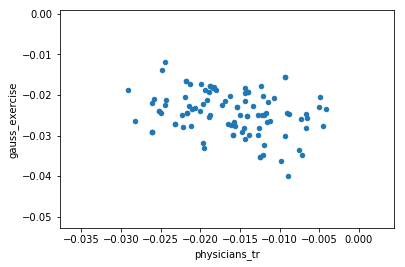

In [41]:
ols_cty_nona_df3.plot(x='physicians_tr',y='gauss_exercise',kind='scatter')

Not so bad ... let's export the risk factors for working with Plotly ...

In [42]:
ols_cty_nona_df3.to_csv('Source_Data/ols_county_only_risks.csv')

In [43]:
en_cty_nona_df3.to_csv('Source_Data/elasticnet_county_only_risks.csv')